# HE ANALYSIS

In this notebook we use the summary DFs that come from `process_HE_runs.py` (makes summary of the RECO hits per event) and `cut_HE_runs.py` (perform cuts on data).

A per-run spectra shift is performed, and dependencies with other variables are corrected to give a final energy resolution for the peaks.

## Preparing data

In [1]:
import glob
import numpy as np
import pandas as pd
import tables as tb

import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib import cm

cmap = plt.get_cmap('viridis').copy()
cmap.set_under(color='white') 
plot_cmap = cm.get_cmap('turbo_r')

def lineal(x, a, b):
    return a*x + b

def in_range(x, rang):
    return (x > rang[0]) & (x < rang[1])

from scipy.optimize import curve_fit
from scipy.integrate import quad

def gauss(x, a, mu, sigma):
    return a * np.exp(-((x - mu) / sigma) ** 2 / 2)

def expon(x, m, c):
    return m *np.exp(-x/c)

def peak_fit(x, a, mu, sigma, m, c):
    return gauss(x, a, mu, sigma) + expon(x, m, c)

def fit_and_plot_peaks_resolution(data, fun, nbins, plotrange, fitrange, initial_params, bounds, title, density = True, plot = False):
    y, x = np.histogram(data, nbins, range = plotrange, density = density)

    total_counts = len(data)
    bin_width = x[1] - x[0]

    if density:
        yerr = np.sqrt(y) / (bin_width * total_counts)
    else:
        yerr = np.sqrt(y)
    
    # Prevent zero errors
    yerr[yerr == 0] = np.min(yerr[yerr > 0]) if np.any(yerr > 0) else 1.0
    
    # from the xbins we select the range to plot, otherwise things don't match
    fit_mask = (x > fitrange[0]) & (x < fitrange[1])
    fit_x, fit_y, fit_yerr = x[fit_mask], y[fit_mask[:-1]], yerr[fit_mask[:-1]]
    params, cov = curve_fit(fun, fit_x, fit_y, p0=initial_params, sigma=fit_yerr, bounds = bounds, maxfev = 2000, absolute_sigma = True)
    err = np.sqrt(np.diag(cov))
    a, mu, sigma, m, c = params[0], params[1], params[2], params[3], params[4]
    yfit = fun(fit_x, a, mu, sigma, m, c)

    R = 2 * np.sqrt(2 * np.log(2)) * sigma * 100 / mu
    sR = R * np.sqrt((err[2] / sigma) **2 + (err[1]/mu)**2)

    if plot:
        legend_string = r'$\mu={:.3f} \pm {:.3e}$'.format(mu, err[1]) + '\n' + \
                        r'$\sigma={:.3f} \pm {:.3e}$'.format(sigma, err[2]) + '\n' + \
                        r'R(%) = ${:.3f} \pm {:.3e}$'.format(R, sR)
        plt.hist(data, nbins, range = plotrange, histtype='step', density = density)
        plt.errorbar(0.5 * (x[:-1] + x[1:]), y, yerr=yerr, fmt = ' ', c='tab:blue', alpha = 0.5)
        plt.plot(fit_x, yfit, 'r-', label = legend_string)
        plt.legend()
        plt.xlabel('E (MeV)')
        if density:
            plt.ylabel('Probability density (1 / MeV)')
        else:
            plt.ylabel('Events')
        plt.title(title)
        plt.grid()
        plt.show()
    return [params, err], [R, sR]

def fit_whole_peaks(df, var, model, range, nbins, initial_params = None, bounds = ([0, 0, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf]), density = False, title = '', plot = False):
    data = df[in_range(df[var], range)][var]

    y, x = np.histogram(data, nbins)
    if initial_params is None:
        A0 = max(y) - min(y)
        mu0 = x[np.argmax(y)]

        half_max = np.max(y) / 2
        indices = np.where(y > half_max)[0]
        fwhm = x[indices[-1]] - x[indices[0]]

        sig0 = fwhm / (2 * np.sqrt(2 * np.log(2)))  # FWHM = 2.355 * sigma
        m0 = np.min(y)

        initial_params = [A0, mu0, sig0, m0, 1]

    par, res = fit_and_plot_peaks_resolution(data, 
                                            model,
                                            nbins, 
                                            range, 
                                            range, 
                                            initial_params, 
                                            bounds, 
                                            title, 
                                            density=density, 
                                            plot = plot)
    return par, res

In [2]:
run_numbers = [15589, 15590, 15591, 15592, 15593, 15594, 15596, 15597] #, 15604, 15605, 15607]

run_folder = 'HE_runs'
run_summary_name = 'run_cut_{}.h5'
wf_selection_name = 'sel_wf_{}.h5'

path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/{run_folder}/{run_number}/'

In [3]:
nlines = len(run_numbers)

min_val, max_val = 0.08, 0.9  
plot_colors = [plot_cmap(min_val + (max_val - min_val) * i / (nlines - 1)) for i in range(nlines)]

Join all run DST, RECO and efficiency information:

In [4]:
dst_summ, reco_summ, eff_summ = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])
for run_n in run_numbers:
    save_path_summary = path.format(run_folder = run_folder, run_number = run_n) + run_summary_name.format(run_n)
    run_dst  = pd.read_hdf(save_path_summary, 'DST/Events')
    run_dst['run_n'] = str(run_n)
    run_reco = pd.read_hdf(save_path_summary, 'RECO/Events_summary')
    eff = pd.read_hdf(save_path_summary, 'RUN/eff')
    eff['run_n'] = run_n

    dst_summ = dst_summ.append(run_dst)
    reco_summ = reco_summ.append(run_reco)
    eff_summ = eff_summ.append(eff)


Fill with 0 some NaNs from those variables (forgot to do it in the script) and then correct the energy by the outer dropped hits energy.

In [5]:
reco_summ = reco_summ.fillna({'Ec_drop_in': 0, 'Ec_drop_out':0})
reco_summ['total_energy_d'] = reco_summ['total_energy'] - reco_summ['Ec_drop_out'] # - reco_summ['Ec_drop_in']

## Efficiences

Check the efficiency of the cuts of each run

Text(0, 0.5, 'Eff (%)')

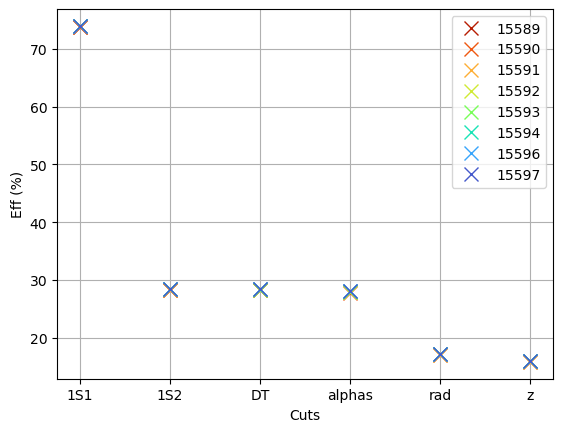

In [6]:
for run_n, c in zip(run_numbers, plot_colors):
    plt.plot(['1S1', '1S2', 'DT', 'alphas', 'rad', 'z'], (eff_summ[eff_summ.run_n == run_n][['1S1', '1S2', 'DT', 'alphas', 'rad', 'z']] / eff_summ[eff_summ.run_n == run_n][['total']].values).T * 100, 'x', color = c, markersize = 10, label = run_n)
plt.grid()
plt.legend()
plt.xlabel('Cuts')
plt.ylabel('Eff (%)')

## Energy spectra

Plot the energy spectra (and the corrected spectra, which is marked with a `_d` for "dropped hits")

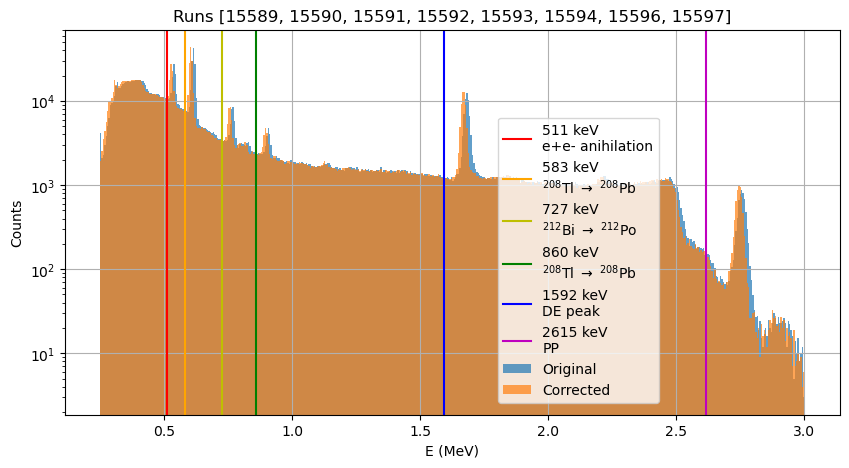

In [7]:
plt.figure(figsize=(10, 5))
plt.hist(reco_summ.total_energy, 500, (0.25, 3), alpha = 0.7, label = 'Original')
plt.hist(reco_summ.total_energy_d, 500, (0.25, 3), alpha = 0.7, label = 'Corrected')


plt.axvline(0.511, c = 'r', label = '511 keV\ne+e- anihilation')
plt.axvline(0.583, c = 'orange', label = '583 keV\n' + r'$^{208}$Tl $\rightarrow$ $^{208}$Pb')
plt.axvline(0.727, c = 'y', label = '727 keV\n' + r'$^{212}$Bi $\rightarrow$ $^{212}$Po')
plt.axvline(0.860, c = 'g', label = '860 keV\n' + r'$^{208}$Tl $\rightarrow$ $^{208}$Pb')
plt.axvline(1.592, c = 'b', label = '1592 keV\nDE peak')
plt.axvline(2.615, c = 'm', label = '2615 keV\nPP')
plt.grid()
plt.yscale('log')
plt.title('Runs {}'.format(run_numbers))
plt.xlabel('E (MeV)')
plt.ylabel('Counts')
plt.legend(loc = 'upper left', bbox_to_anchor = (0.55, 0.79))

## Energy scale

To get a good resolution of the peaks when joining several runs, we should fix the energy scale run by run.

In this section, we get the peak centers (`get_peak_centers`) run by run. Then, we fit the Real vs Measured peak energy to a line with slope m and interceipt b (`energy_scale_fit`), and shift the whole spectra by it, using:

$$E_{shift} = E * m + b $$ 

In [8]:
def get_peak_centers(run_numbers, reco_summ, variable, peak_ranges, npeaks = 4, plot = True):
    peak_nbins = [100, 100, 60, 40, 100, 25]
    peak_names  = ['e+e- anihilation (511 keV)', r'$^{208}$Tl $\rightarrow$ $^{208}$Pb (583 keV)', r'$^{212}$Bi $\rightarrow$ $^{212}$Po (727 keV)', r'$^{208}$Tl $\rightarrow$ $^{208}$Pb (860 keV)', '1592 keV\nDEP', '2615 keV\nPP']

    ranges = peak_ranges[:npeaks]
    nbins  = peak_nbins[:npeaks]
    names  = peak_names[:npeaks]
    
    meas_peaks = {}
    for run_n in run_numbers:
        run_reco = reco_summ[reco_summ.run_n == str(run_n)]
        meas_val, meas_err = [], []
        for rang, nbin, name in zip(ranges, nbins, names):
            par, res = fit_whole_peaks(run_reco, variable, peak_fit, rang, nbin, title = 'Run {} - '.format(run_n) + name, plot = plot)
            meas_val.append(par[0][1])
            meas_err.append(par[1][1])
        meas_peaks[run_n] = [meas_val, meas_err]
    return meas_peaks

def energy_scale_fit(meas_peaks, run_numbers, plot_colors, npeaks = 4):
    real_peaks = [0.511, 0.583, 0.727, 0.86, 1.592, 2.615]
    color_peak = ['r', 'orange', 'y', 'g', 'b', 'm']
    real_peaks = real_peaks[:npeaks]
    color_peak = color_peak[:npeaks]
    
    parameters = {}
    for run_n, c in zip(run_numbers, plot_colors):
        if run_n not in meas_peaks.keys(): continue
        if len(meas_peaks[run_n][0]) == 0: continue
        for m_, r_, c_ in zip(meas_peaks[run_n][0], real_peaks, color_peak):
            plt.plot(m_, r_, '.', color = c_)
        par, err  = curve_fit(lineal, meas_peaks[run_n][0], real_peaks, p0 = (1, 0))
        plt.plot(meas_peaks[run_n][0], lineal(np.array(meas_peaks[run_n][0]), *par), color = c, label = str(run_n) + '\n m = {:.2e}'.format(par[0]) + '\n n = {:.2e}'.format(par[1]))
        parameters[run_n] = par
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.grid()
    plt.xlabel('Measured peak energy (MeV)')
    plt.ylabel('Real peak energy (MeV)')
    return parameters


def plot_real_vs_meas_peaks(meas_peaks, run_numbers, plot_colors, npeak = 4):
    real_peaks = [0.511, 0.583, 0.727, 0.86, 1.592, 2.615]
    real_peaks = real_peaks[:npeak]
    for run_n, c in zip(run_numbers, plot_colors):
        if run_n not in meas_peaks.keys(): continue
        if len(meas_peaks[run_n][0]) == 0: continue
        m_ = np.array(meas_peaks[run_n][0])
        e_ = np.array(meas_peaks[run_n][1])
        r_ = np.array(real_peaks)
        plt.errorbar(r_, ((m_ - r_) / r_) * 100, yerr = e_ * 100, color = c, markersize = 10, label = run_n, marker = '.', capsize=2)
    plt.legend()
    plt.grid()
    plt.xlabel('Real peak energy (MeV)')
    plt.ylabel('(Measured - Real) / Real peak energy (%)')

In [9]:
peak_ranges = [(0.5, 0.58), (0.58, 0.65), (0.72, 0.81), (0.85, 0.95), (1.62, 1.75), (2.7, 2.8)]
peak_ranges_d = [(0.48, 0.56), (0.57, 0.64), (0.71, 0.80), (0.85, 0.95), (1.59, 1.72), (2.69, 2.79)]

Obtaining the measured peaks (for both the regular spectra and the corrected by the outer dropped hits energy), and from them the shifting parameters

In [10]:
meas_peaks = get_peak_centers(run_numbers, reco_summ, 'total_energy', peak_ranges, npeaks=6, plot = False)
meas_peaks_d = get_peak_centers(run_numbers, reco_summ, 'total_energy_d', peak_ranges_d, npeaks = 6, plot = False)

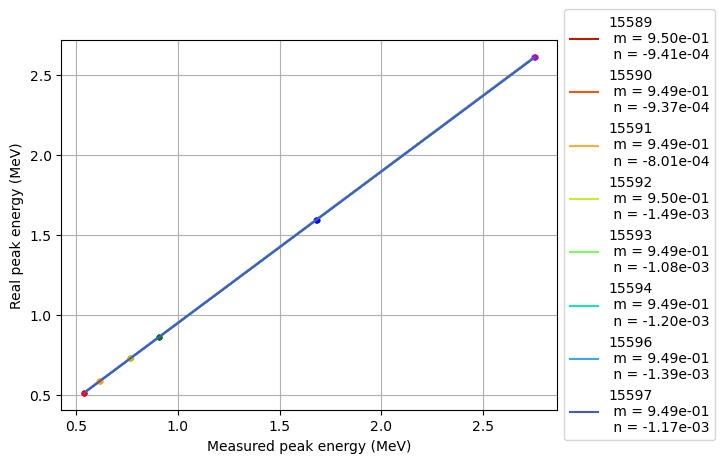

In [11]:
param = energy_scale_fit(meas_peaks, run_numbers, plot_colors, npeaks = 6)

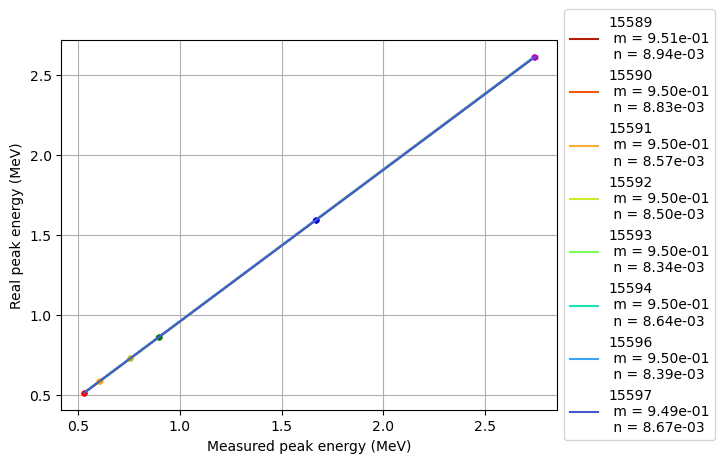

In [12]:
param_d = energy_scale_fit(meas_peaks_d, run_numbers, plot_colors, npeaks = 6)

We can plot how much each peak differ from the real value

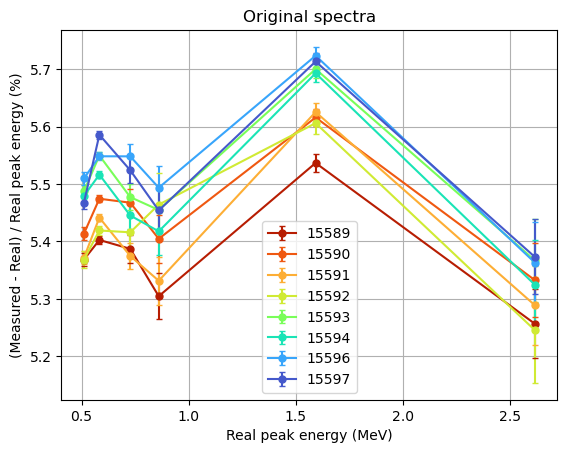

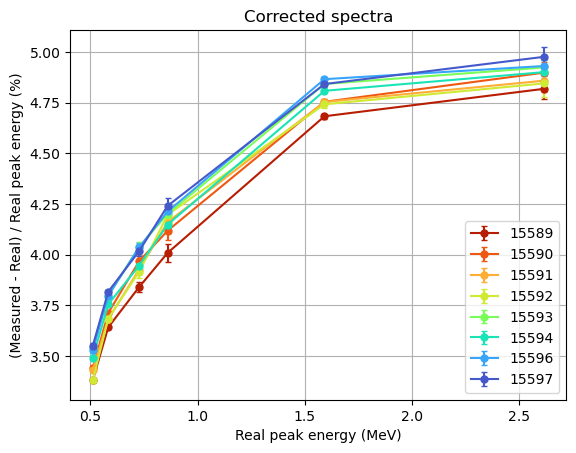

In [13]:
plot_real_vs_meas_peaks(meas_peaks, run_numbers, plot_colors, npeak = 6)
plt.title('Original spectra')
plt.show()
plot_real_vs_meas_peaks(meas_peaks_d, run_numbers, plot_colors, npeak = 6)
plt.title('Corrected spectra')
plt.show()

Doing the correction using the obtained parameters

In [14]:
reco_summ['E_shifted']   = reco_summ['total_energy'] * reco_summ['run_n'].map(lambda r: param[int(r)][0]) + reco_summ['run_n'].map(lambda r: param[int(r)][1])
reco_summ['E_shifted_d'] = reco_summ['total_energy_d'] * reco_summ['run_n'].map(lambda r: param_d[int(r)][0]) + reco_summ['run_n'].map(lambda r: param_d[int(r)][1])

Plotting the shifted spectras

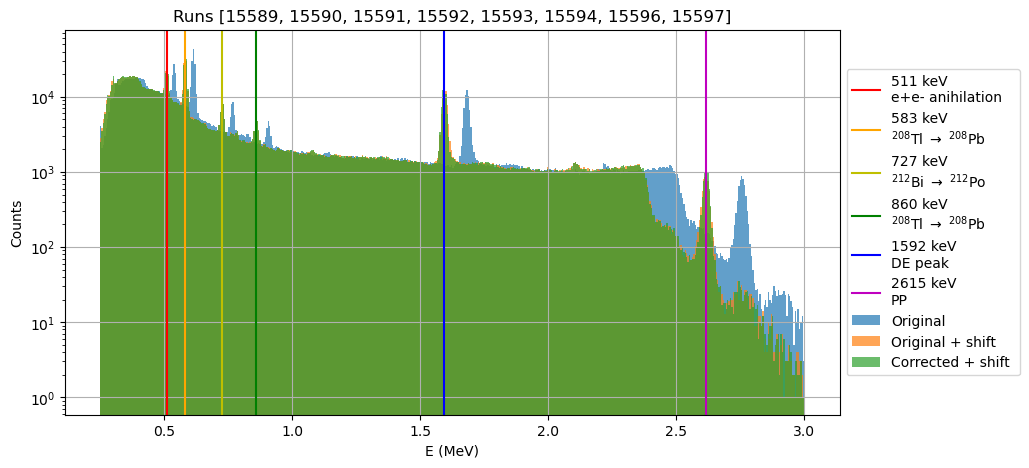

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(reco_summ.total_energy, 500, (0.25, 3), alpha = 0.7, label = 'Original')
plt.hist(reco_summ.E_shifted, 500, (0.25, 3), alpha = 0.7, label = 'Original + shift')
plt.hist(reco_summ.E_shifted_d, 500, (0.25, 3), alpha = 0.7, label = 'Corrected + shift ')

plt.grid()
plt.yscale('log')
plt.axvline(0.511, c = 'r', label = '511 keV\ne+e- anihilation')
plt.axvline(0.583, c = 'orange', label = '583 keV\n' + r'$^{208}$Tl $\rightarrow$ $^{208}$Pb')
plt.axvline(0.727, c = 'y', label = '727 keV\n' + r'$^{212}$Bi $\rightarrow$ $^{212}$Po')
plt.axvline(0.860, c = 'g', label = '860 keV\n' + r'$^{208}$Tl $\rightarrow$ $^{208}$Pb')
plt.axvline(1.592, c = 'b', label = '1592 keV\nDE peak')
plt.axvline(2.615, c = 'm', label = '2615 keV\nPP')
plt.title('Runs {}'.format(run_numbers))
plt.xlabel('E (MeV)')
plt.ylabel('Counts')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

We can get again the peak centers, now for the shifted spectras, to check how much they still differ from the original values

In [16]:
peak_ranges_shift = [(0.48, 0.55), (0.55, 0.61), (0.7, 0.76), (0.83, 0.89), (1.52, 1.67), (2.55, 2.67)]

In [17]:
meas_peaks_shift = get_peak_centers(run_numbers, reco_summ, 'E_shifted', peak_ranges_shift, npeaks=6, plot = False)
meas_peaks_shift_d = get_peak_centers(run_numbers, reco_summ, 'E_shifted_d', peak_ranges_shift, npeaks=6, plot = False)

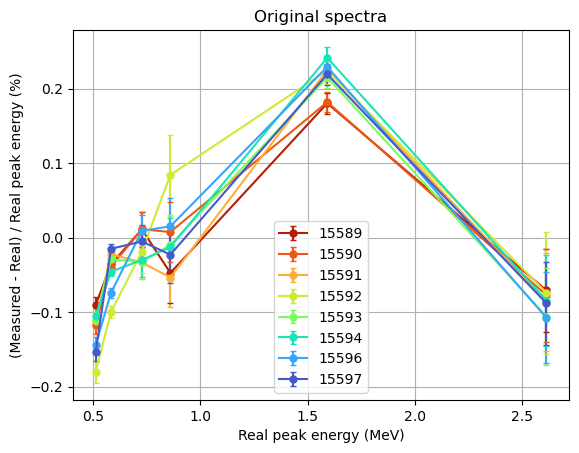

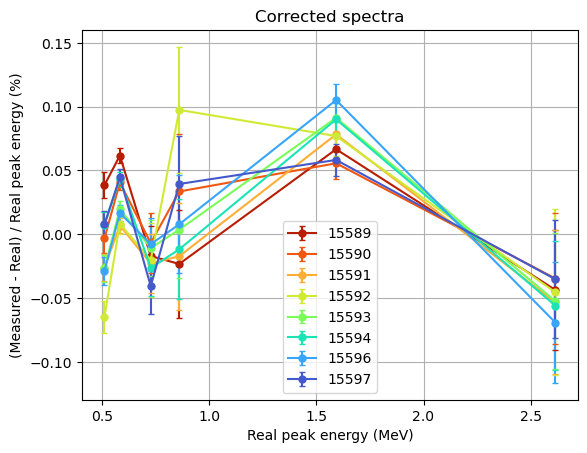

In [18]:
plot_real_vs_meas_peaks(meas_peaks_shift, run_numbers, plot_colors, npeak=6)
plt.title('Original spectra')
plt.show()
plot_real_vs_meas_peaks(meas_peaks_shift_d, run_numbers, plot_colors, npeak=6)
plt.title('Corrected spectra')
plt.show()

## Energy resolution

We can do a first estimation of the energy resolution now that the energy scale has been fixed run by run. In this case I'm doing it for the corrected spectra by the outer dropped energy hits.

In [19]:
ene_var_corr = 'E_shifted_d'

dep_range = (1.565, 1.62)
dep_nbins = 120
pp_range = (2.58, 2.65)
pp_nbins = 70

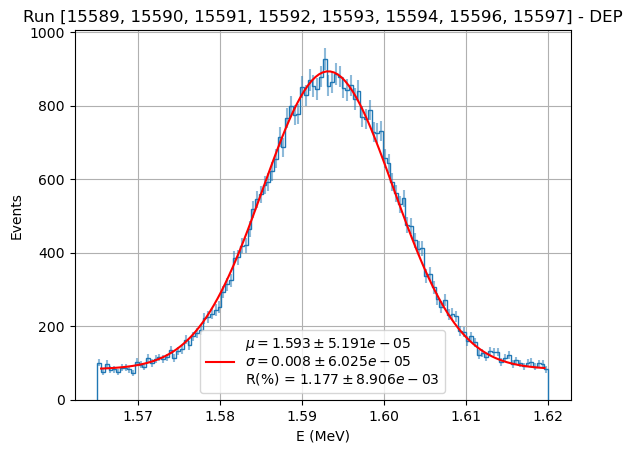

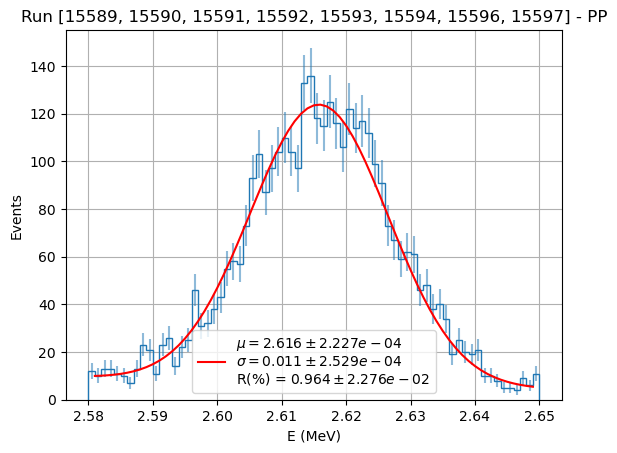

Energy resolution DEP: 1.177 ± 0.009 %
Energy resolution PP: 0.964 ± 0.023 %


In [20]:
_, r_dep = fit_whole_peaks(reco_summ[reco_summ.Rmax < 400], ene_var_corr, peak_fit, dep_range, dep_nbins, title = 'Run {} - '.format(run_numbers) + 'DEP', plot = True)
plt.show()
_, r_pp  = fit_whole_peaks(reco_summ[reco_summ.Rmax < 400], ene_var_corr, peak_fit, pp_range, pp_nbins, title = 'Run {} - '.format(run_numbers) + 'PP', plot = True)
plt.show()
print('Energy resolution DEP: {:.3f} ± {:.3f} %'.format(r_dep[0], r_dep[1]))
print('Energy resolution PP: {:.3f} ± {:.3f} %'.format(r_pp[0], r_pp[1]))

## Energy dependencies

In [21]:
from invisible_cities.core.fit_functions import expo
from invisible_cities.core.fit_functions import profileX
from scipy.optimize                      import curve_fit

def quad(x, a, b, c):
    return a*x**2 + b*x + c


def plot_profile(df, xvar, yvar, fitfun = None, initial_values = None, std = False, fitbins = 20, plotbins = (50, 50), fitrange = (None, None), plotrange = (None, None), axlabel = ['', ''], units = ['mm', 'MeV'], title = '', cmap = 'viridis'):
    x, y, sy = profileX(df[xvar], df[yvar], std=std, nbins = fitbins, xrange = fitrange[0], yrange=fitrange[1])
    par = None
    if fitfun:
        par, err  = curve_fit(fitfun, x, y, sigma=sy, p0 = initial_values)
        label_lines = [f'$x_{{{i}}}$ = {p:.2e} ' + r'$\mathrm{' + units[1] + r'}/\mathrm{' + units[0] + r'}^{{' + f'{i}' + '}}$' for i, p in enumerate(par[::-1])]
        label = "\n".join(label_lines)

        plt.plot(x, fitfun(x, *par), 'r-', label = label)
    plt.errorbar(x = x, y = y, yerr = sy, fmt = 'r.')

    plt.hist2d(df[xvar], df[yvar], bins = plotbins, range = plotrange, cmap = cmap, vmin = 1e-3)
    plt.xlabel(axlabel[0] + ' ({})'.format(units[0]))
    plt.ylabel(axlabel[1] + ' ({})'.format(units[1]))
    plt.legend()
    plt.title(title)
    plt.show()
    if type(par) != None: 
        return par
    
def plot_hist2d(df, xvar, yvar, plotbins = (50, 50), plotrange = (None, None), axlabel = ['', ''], units = ['mm', 'MeV'], title = '', cmap = 'viridis'):
    plt.hist2d(df[xvar], df[yvar], bins = plotbins, range = plotrange, cmap = cmap, vmin = 1e-3)
    plt.xlabel(axlabel[0] + ' ({})'.format(units[0]))
    plt.ylabel(axlabel[1] + ' ({})'.format(units[1]))
    plt.title(title)
    plt.show()

In [22]:
reco_summ = reco_summ.merge(dst_summ[['event', 'run_n', 'S1e', 'S2e']], on = ['event', 'run_n'])

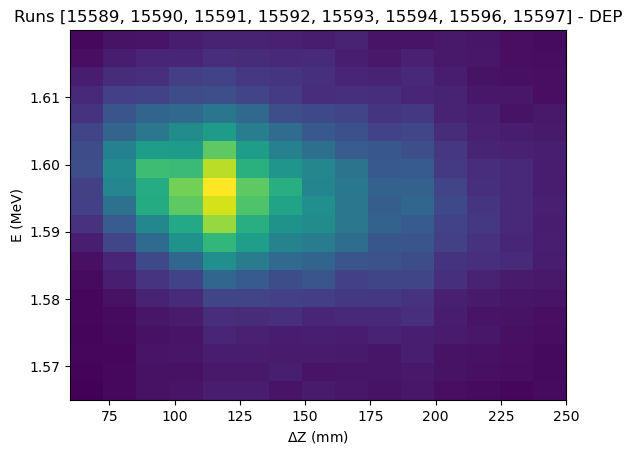

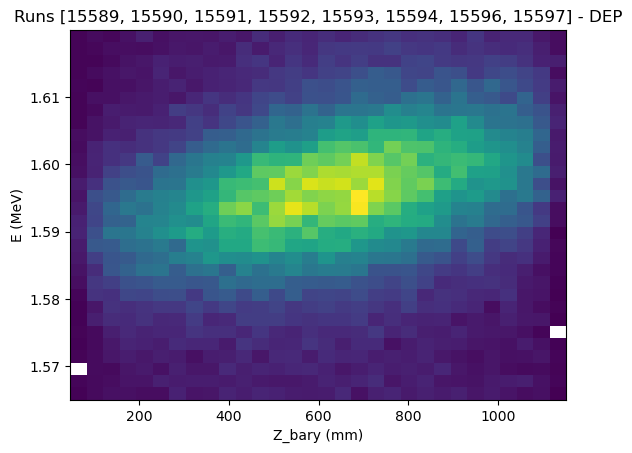

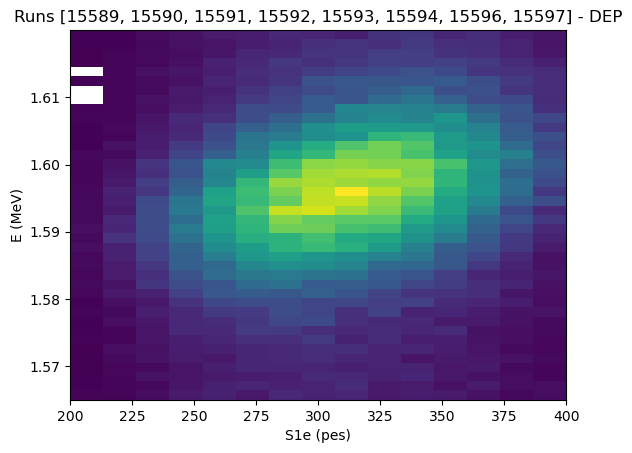

In [23]:
plot_hist2d(reco_summ[in_range(reco_summ['E_shifted'], dep_range)], 'dZ', 'E_shifted', plotbins=(15, 20), plotrange=((60, 250), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)
plot_hist2d(reco_summ[in_range(reco_summ['E_shifted'], dep_range)], 'Z_bary', 'E_shifted', plotbins=(30, 30), plotrange=(None, None), axlabel = ['Z_bary', 'E'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)
plot_hist2d(reco_summ[in_range(reco_summ['E_shifted'], dep_range)], 'S1e', 'E_shifted', plotbins=(15, 40), plotrange=((200, 400), None), axlabel = ['S1e', 'E'], units = ['pes', 'MeV'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)

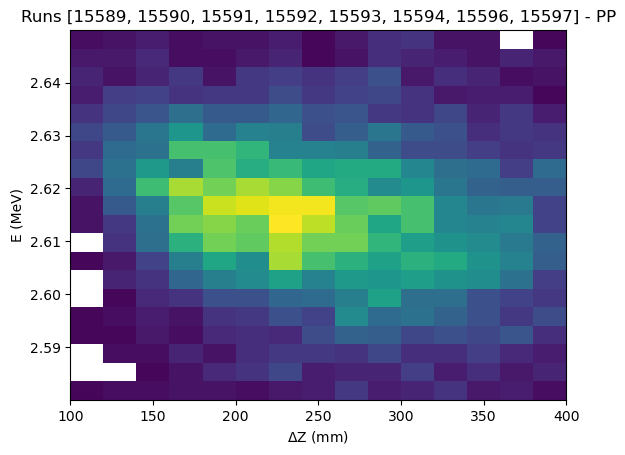

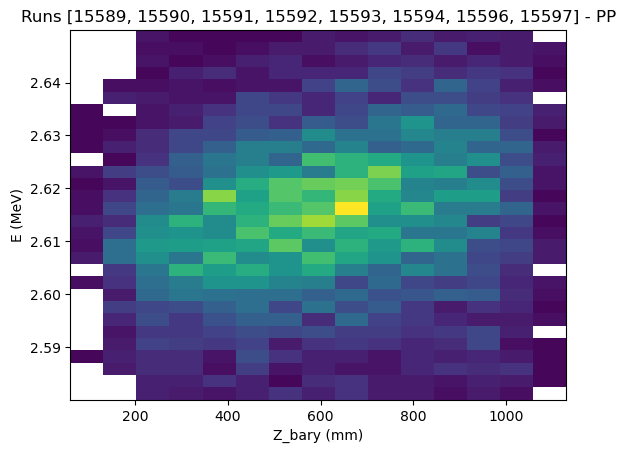

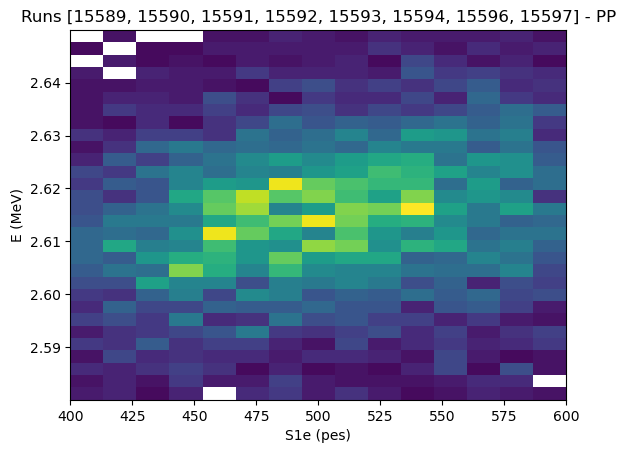

In [24]:
plot_hist2d(reco_summ[in_range(reco_summ['E_shifted'], pp_range)], 'dZ', 'E_shifted', plotbins=(15, 20), plotrange=((100, 400), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)
plot_hist2d(reco_summ[in_range(reco_summ['E_shifted'], pp_range)], 'Z_bary', 'E_shifted', plotbins=(15, 30), plotrange=(None, None), axlabel = [r'Z_bary', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)
plot_hist2d(reco_summ[in_range(reco_summ['E_shifted'], pp_range)], 'S1e', 'E_shifted', plotbins=(15, 30), plotrange=((400, 600), None), axlabel = [r'S1e', 'E'], units = ['pes', 'MeV'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)

We see that:
* **$\Delta$ Z** was solved for DEP after the dropping out hits energy correction, but not for PP
* **Z_bary** is still an issue for now
* **S1e** gets mainly solved after correcting **Z_bary**, so we will not correct by it


## Energy dependencies correction

Following [JHEP 2019:230 (2019)](https://arxiv.org/abs/1905.13110), we will do a profile on the desired variable, and perform a linear fit:

$$E = x_0 + x * x_1$$

To correct the energy, we do:

$$E_{corr} = \frac{E_0}{1 + \frac{x_1}{x_0} * x}$$

### $\Delta$ Z

As I said before, I will correct just the PP by $\Delta$ Z

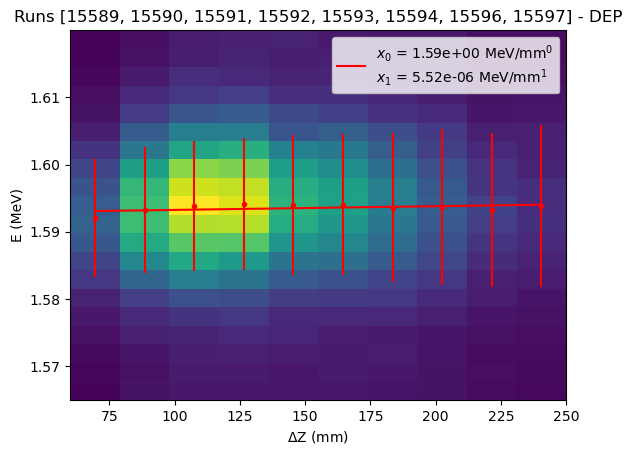

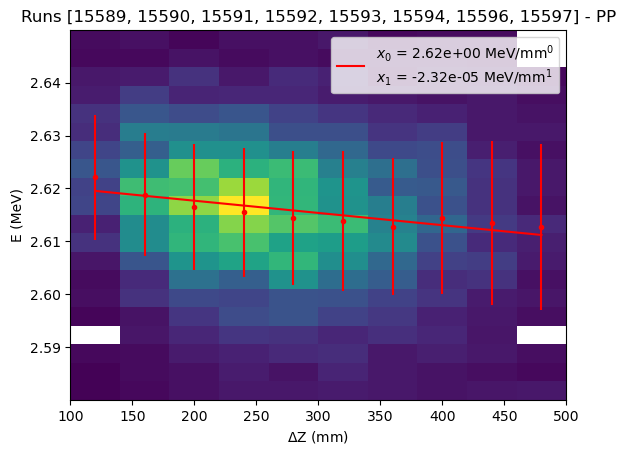

In [25]:
par_DEP_dZ = plot_profile(reco_summ[in_range(reco_summ[ene_var_corr], dep_range)], 'dZ', ene_var_corr, fitfun=lineal, initial_values=(0, 1.67), std = True, fitbins=10, plotbins=(10, 20), fitrange=((60, 250), None), plotrange=((60, 250), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)
par_PP_dZ = plot_profile(reco_summ[in_range(reco_summ[ene_var_corr], pp_range)], 'dZ', ene_var_corr, fitfun=lineal, initial_values=(0, 1.67), std = True, fitbins=10, plotbins=(10, 20), fitrange=((100, 500), None), plotrange=((100, 500), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)

In [26]:
dp_correct = reco_summ[in_range(reco_summ[ene_var_corr], dep_range)].copy()
pp_correct = reco_summ[in_range(reco_summ[ene_var_corr], pp_range)].copy()

# NO CORRECT IN DZ FOR DEP
dp_correct['E_dZ'] =  dp_correct[ene_var_corr] #/ (1 + (par_DEP_dZ[0] / par_DEP_dZ[1]) * dp_correct.dZ)
pp_correct['E_dZ'] =  pp_correct[ene_var_corr] / (1 + (par_PP_dZ[0] / par_PP_dZ[1]) * pp_correct.dZ)

Let's check how the other dependencies would have changed (just for PP)

The corrected variable:


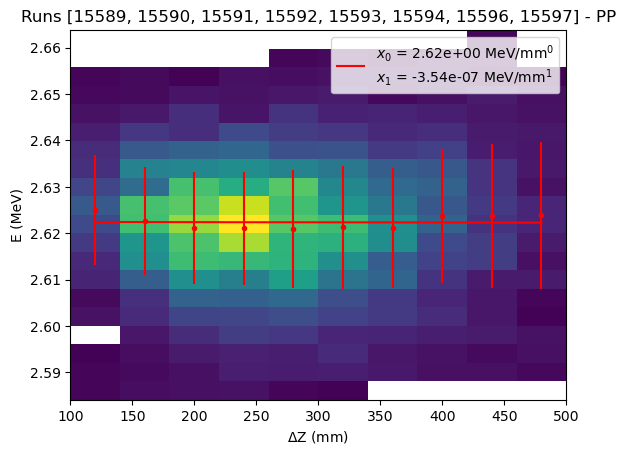

The other variables:


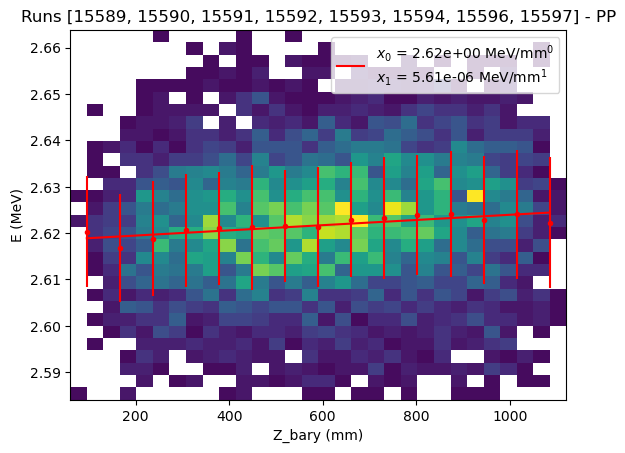

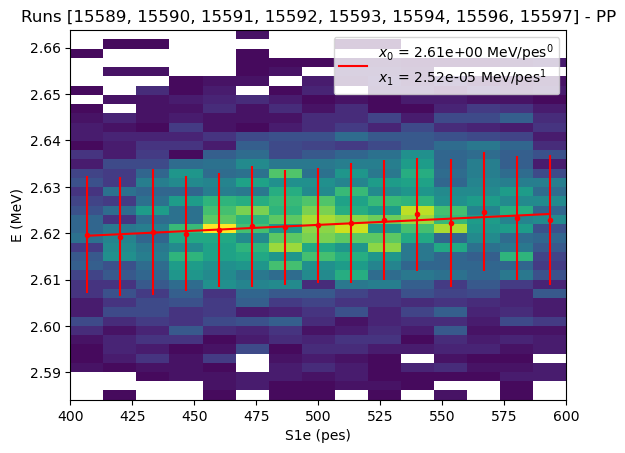

array([2.51536083e-05, 2.60921180e+00])

In [27]:
print('The corrected variable:')
plot_profile(pp_correct, 'dZ', 'E_dZ', fitfun=lineal, initial_values=(0, 1.67), std = True, fitbins=10, plotbins=(10, 20), fitrange=((100, 500), None), plotrange=((100, 500), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)
print('The other variables:')
plot_profile(pp_correct, 'Z_bary', 'E_dZ', fitfun=lineal, initial_values=(0, 1.67), std = True, fitbins=15, plotbins=(30, 30), fitrange=(None, None), plotrange=(None, None), axlabel = [r'Z_bary', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)
plot_profile(pp_correct, 'S1e', 'E_dZ', fitfun=lineal, initial_values=(1.67, 0), std = True, fitbins=15, plotbins=(15, 40), fitrange=((400, 600), None), plotrange=((400, 600), None), axlabel = [r'S1e', 'E'], units = ['pes', 'MeV'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)

And now the resulting resolution:

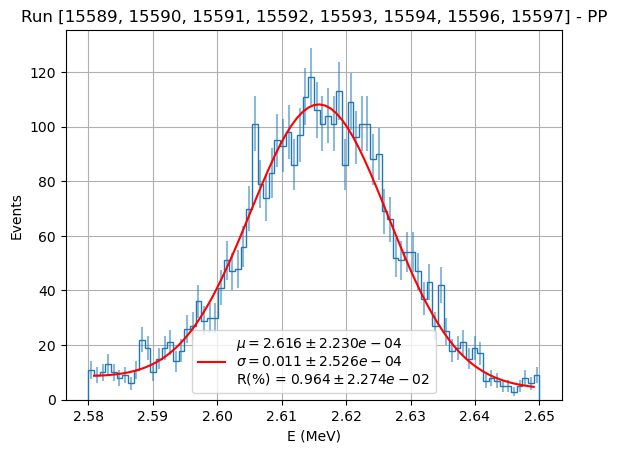

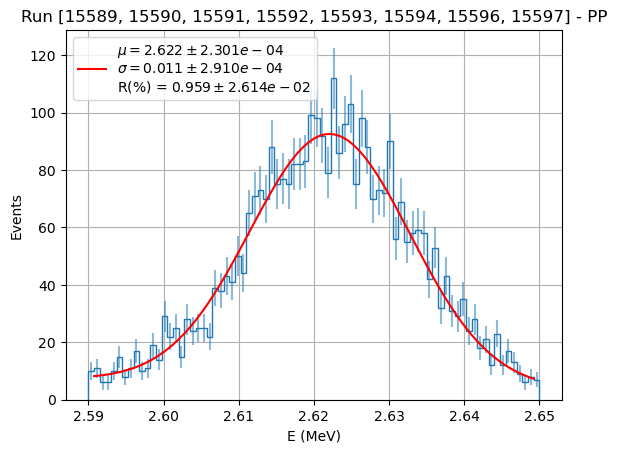

Energy resolution PP: 0.964 ± 0.023 %
Energy resolution PP (dZ corr): 0.959 ± 0.026 %


In [28]:
_, r_pp = fit_whole_peaks(reco_summ[reco_summ.Rmax < 400], ene_var_corr, peak_fit, pp_range, 80, title = 'Run {} - '.format(run_numbers) + 'PP', plot = True)
plt.show()
_, r_pp_dZ = fit_whole_peaks(pp_correct[pp_correct.Rmax < 400], 'E_dZ', peak_fit, (2.59, 2.65), 80, title = 'Run {} - '.format(run_numbers) + 'PP', plot = True)
plt.show()


print('Energy resolution PP: {:.3f} ± {:.3f} %'.format(r_pp[0], r_pp[1]))
print('Energy resolution PP (dZ corr): {:.3f} ± {:.3f} %'.format(r_pp_dZ[0], r_pp_dZ[1]))

### Z_bary

Now we correct in the Z barycenter for both peaks

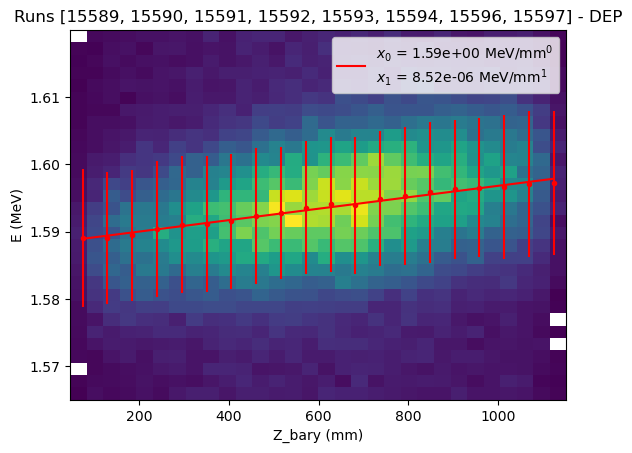

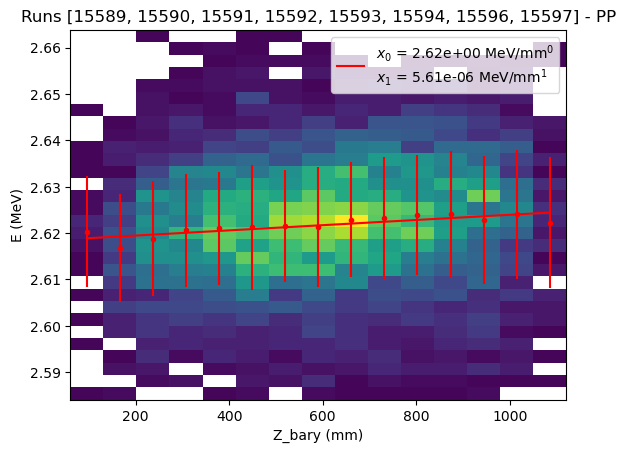

In [29]:
par_DEP_Z = plot_profile(dp_correct, 'Z_bary', 'E_dZ', fitfun=lineal, initial_values=(0, 1.67), std = True, fitbins=20, plotbins=(30, 30), fitrange=(None, None), plotrange=(None, None), axlabel = ['Z_bary', 'E'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)
par_PP_Z = plot_profile(pp_correct, 'Z_bary', 'E_dZ', fitfun=lineal, initial_values=(0, 1.67), std = True, fitbins=15, plotbins=(15, 30), fitrange=(None, None), plotrange=(None, None), axlabel = ['Z_bary', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)


In [30]:
dp_correct['E_Z'] =  dp_correct['E_dZ'] / (1 + (par_DEP_Z[0] / par_DEP_Z[1]) * dp_correct.Z_bary)
pp_correct['E_Z'] =  pp_correct['E_dZ'] / (1 + (par_PP_Z[0] / par_PP_Z[1]) * pp_correct.Z_bary)

Now check other dependencies:

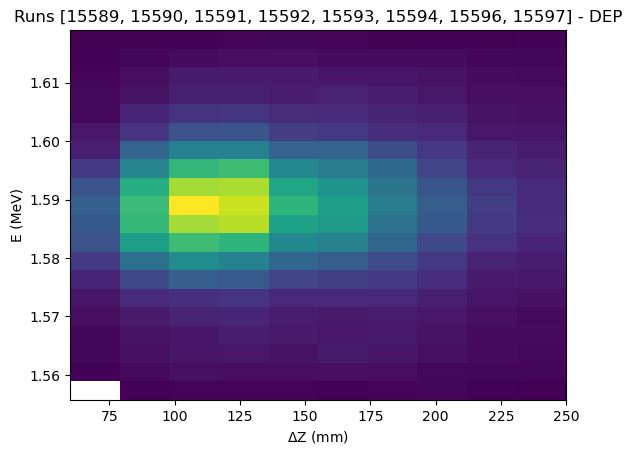

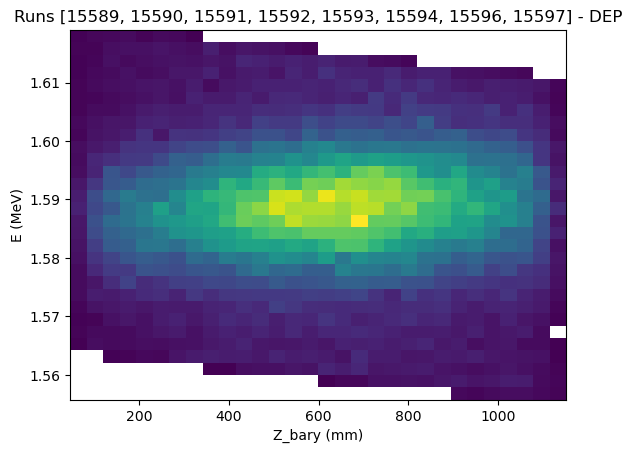

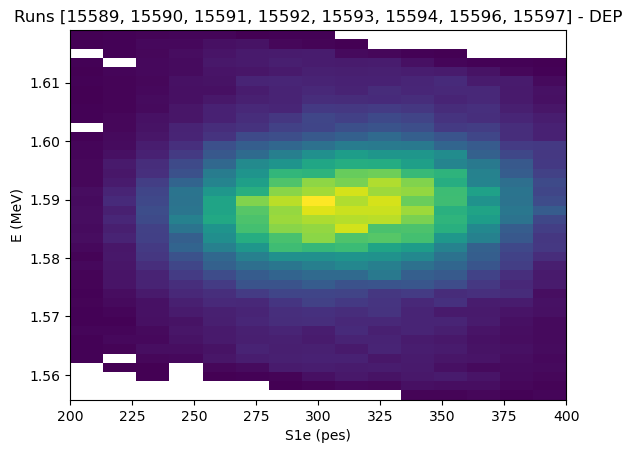

In [31]:
plot_hist2d(dp_correct, 'dZ', 'E_Z', plotbins=(10, 20), plotrange=((60, 250), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)
plot_hist2d(dp_correct, 'Z_bary', 'E_Z', plotbins=(30, 30), plotrange=(None, None), axlabel = [r'Z_bary', 'E'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)
plot_hist2d(dp_correct, 'S1e', 'E_Z', plotbins=(15, 40), plotrange=((200, 400), None), axlabel = ['S1e', 'E'], units = ['pes', 'MeV'], title='Runs {} - DEP'.format(run_numbers), cmap=cmap)


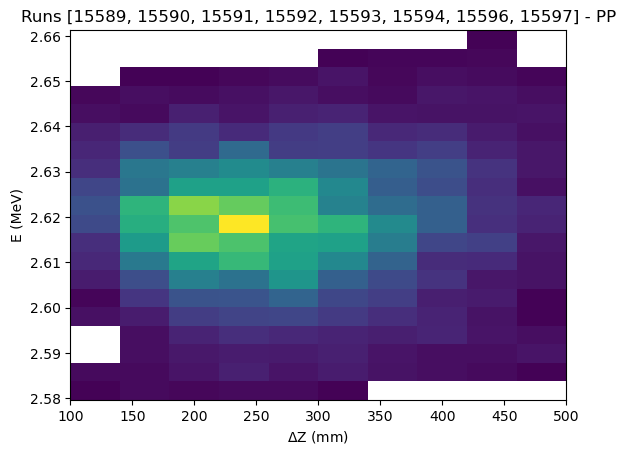

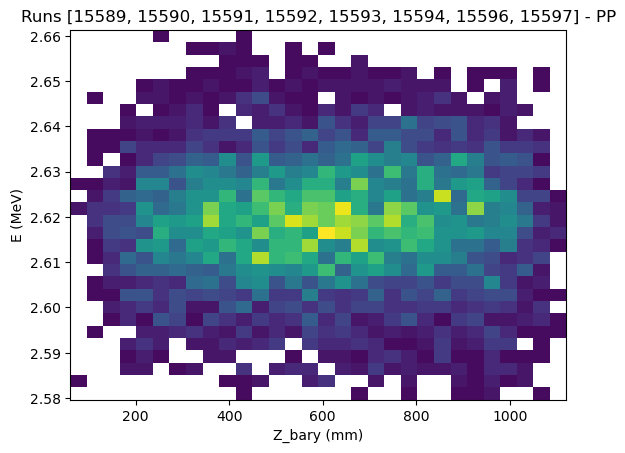

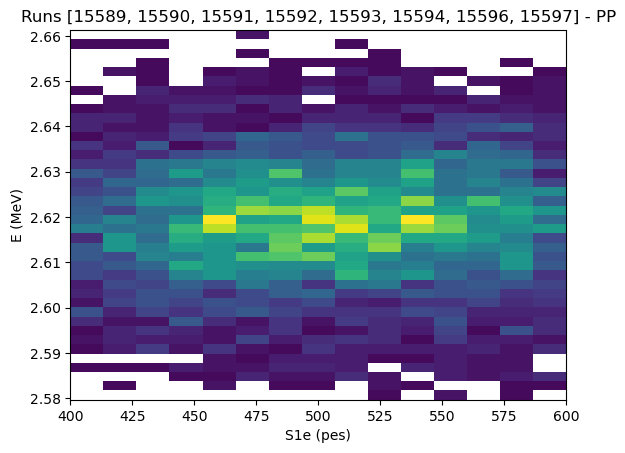

In [32]:
plot_hist2d(pp_correct, 'dZ', 'E_Z', plotbins=(10, 20), plotrange=((100, 500), None), axlabel = [r'$\Delta$Z', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)
plot_hist2d(pp_correct, 'Z_bary', 'E_Z', plotbins=(30, 30), plotrange=(None, None), axlabel = [r'Z_bary', 'E'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)
plot_hist2d(pp_correct, 'S1e', 'E_Z', plotbins=(15, 40), plotrange=((400, 600), None), axlabel = [r'S1e', 'E'], units = ['pes', 'MeV'], title='Runs {} - PP'.format(run_numbers), cmap=cmap)


Most of them are gone now!

And how the resolution has improved for both:

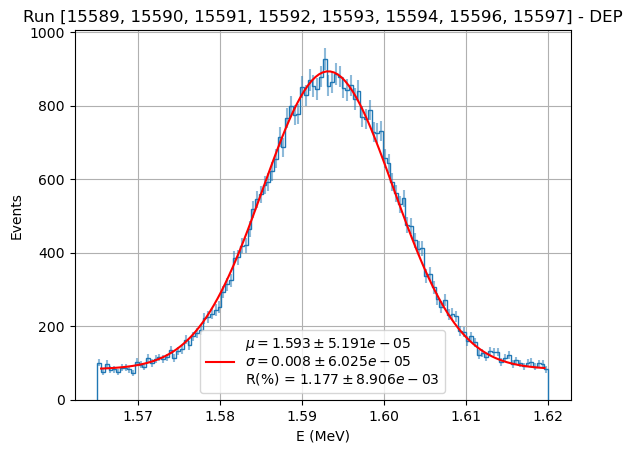

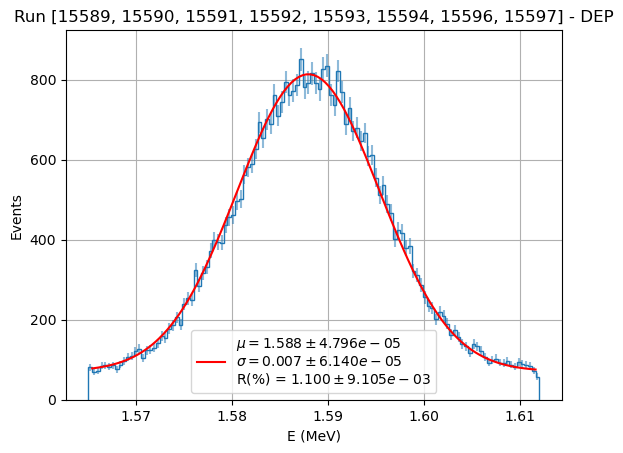

Energy resolution DEP: 1.177 ± 0.009 %
Energy resolution DEP (Z corr): 1.100 ± 0.009 %


In [33]:
_, r_dep = fit_whole_peaks(reco_summ[reco_summ.Rmax < 400], ene_var_corr, peak_fit, dep_range, 120, title = 'Run {} - '.format(run_numbers) + 'DEP', plot = True)
plt.show()
_, r_dep_Z = fit_whole_peaks(dp_correct[dp_correct.Rmax < 400], 'E_Z', peak_fit, (1.565, 1.612), 120, title = 'Run {} - '.format(run_numbers) + 'DEP', plot = True)
plt.show()

print('Energy resolution DEP: {:.3f} ± {:.3f} %'.format(r_dep[0], r_dep[1]))
print('Energy resolution DEP (Z corr): {:.3f} ± {:.3f} %'.format(r_dep_Z[0], r_dep_Z[1]))

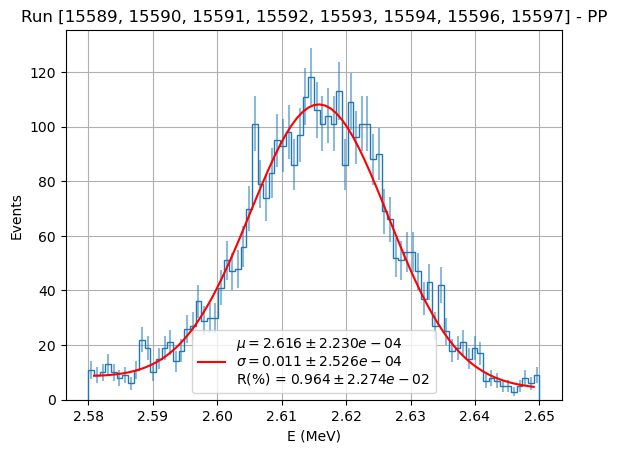

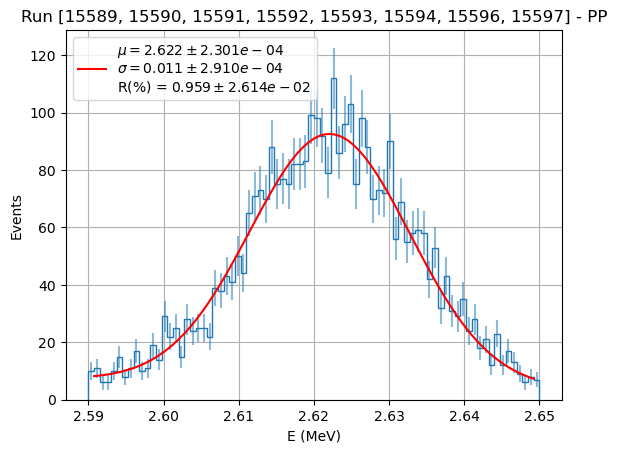

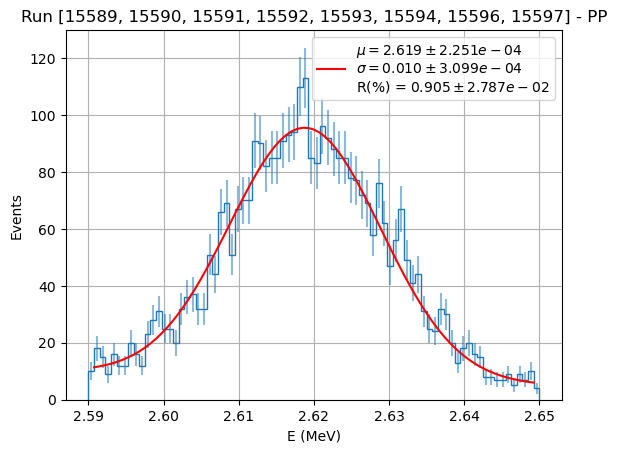

Energy resolution PP: 0.964 ± 0.023 %
Energy resolution PP (dZ corr): 0.959 ± 0.026 %
Energy resolution PP (dZ + Z corr): 0.905 ± 0.028 %


In [34]:
_, r_pp = fit_whole_peaks(reco_summ[reco_summ.Rmax < 400], ene_var_corr, peak_fit, pp_range, 80, title = 'Run {} - '.format(run_numbers) + 'PP', plot = True)
plt.show()
_, r_pp_dZ = fit_whole_peaks(pp_correct[pp_correct.Rmax < 400], 'E_dZ', peak_fit, (2.59, 2.65), 80, title = 'Run {} - '.format(run_numbers) + 'PP', plot = True)
plt.show()
_, r_pp_Z = fit_whole_peaks(pp_correct[pp_correct.Rmax < 400], 'E_Z', peak_fit, (2.59, 2.65), 80, title = 'Run {} - '.format(run_numbers) + 'PP', plot = True)
plt.show()


print('Energy resolution PP: {:.3f} ± {:.3f} %'.format(r_pp[0], r_pp[1]))
print('Energy resolution PP (dZ corr): {:.3f} ± {:.3f} %'.format(r_pp_dZ[0], r_pp_dZ[1]))
print('Energy resolution PP (dZ + Z corr): {:.3f} ± {:.3f} %'.format(r_pp_Z[0], r_pp_Z[1]))